How To Serve As Slides:

    jupyter nbconvert path/to/notebook --to slides --post serve


# Liberating tabular data from the clutches of PDFs      
         
          
           
            
    
**By: Jayant Pahuja   
Data Expert @OpenBudgetsIndia    
Core Team Member @DataKindBlR**

## Budgets 

- What are Budgets ?
- Why are they Important ?
- What can "We" do with them ?

## What does a budget Document look like ?


In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image, HTML

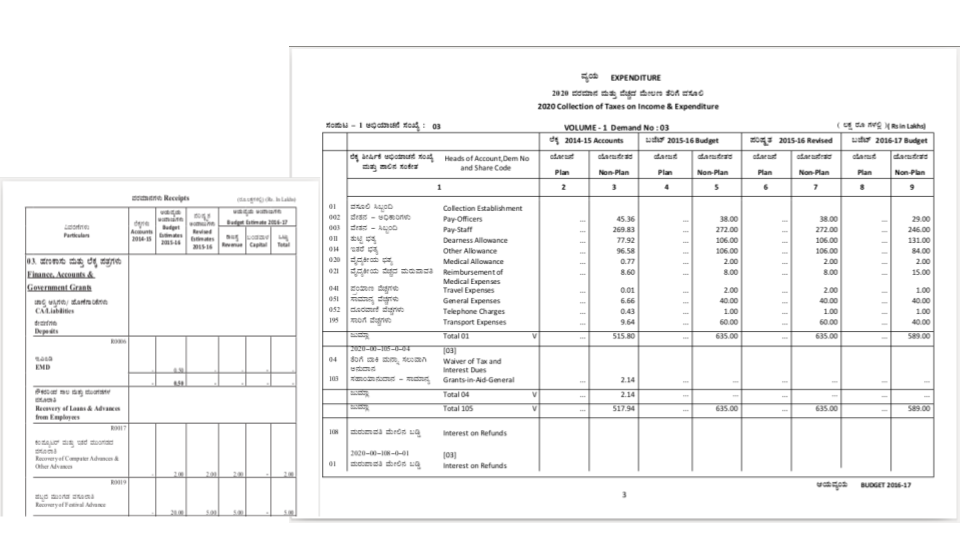

In [26]:
Image('Budget Samples.png')

## Problems with Budget Documents 

- Unstructured PDF documents
- Inconsistent Formats
- No Metadata
- Inconsistent and incomplete Budget Codes aka Unique IDs 


we will be focusing on two of these problems i.e.

Unstructured PDF documents
Inconsistent Formats

And to showcase the techinques further on we will be taking two extreme cases 

1. Karnataka Budget Documents - Tables with structure presented visually
2. West Bengal Documents - Tables with out structural information.

## Karnataka Budget Document

In [27]:
from PyPDF2 import PdfFileReader

# Reading a pdf file
kn_pdf_file_path = 'pdfs/karnataka/Volume-01.pdf'
kn_pdf = PdfFileReader(open(kn_pdf_file_path, 'rb'))

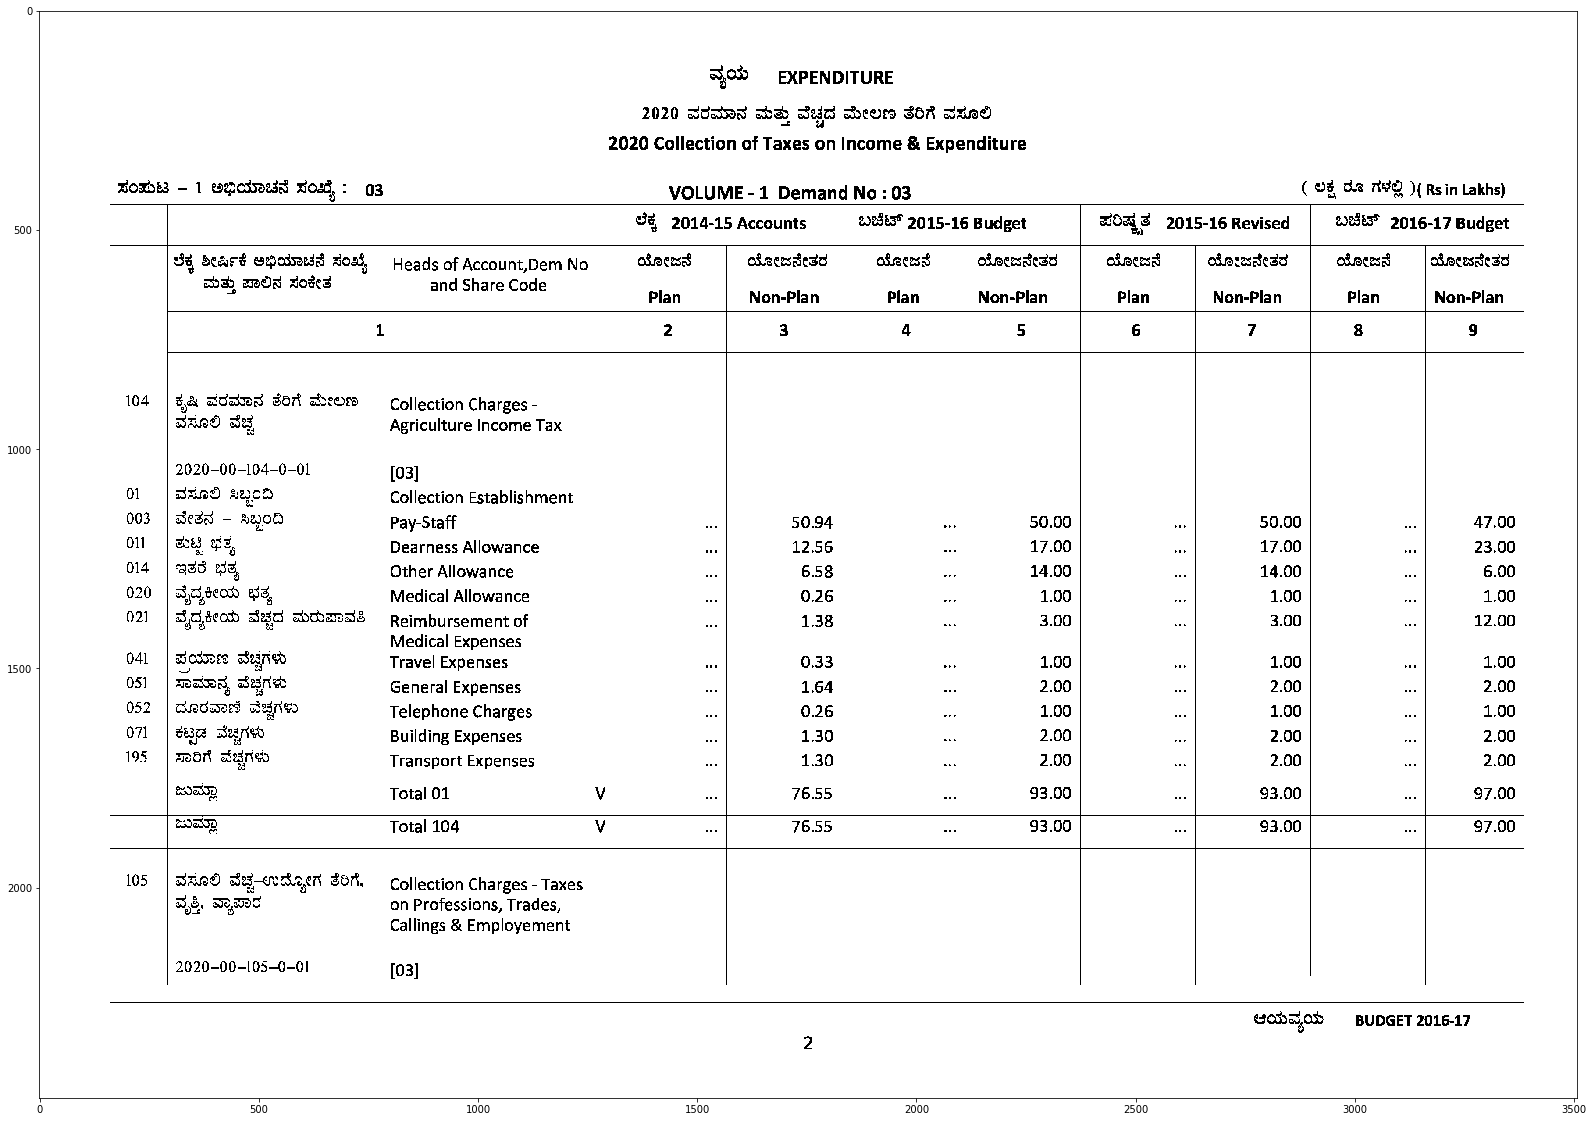

In [28]:
import cv2
import subprocess

# Converting a pdf page into an Image for processing
def get_page_image_from_pdf(page_num, image_file_name, pdf_file_path):
    '''
    Convert a pdf page into an image using imagemagick's convert utility 
    '''
    command = "convert -density 300 '%s'[%s] '%s'" % (pdf_file_path,
                                                      page_num,
                                                      image_file_name)
    subprocess.check_output(command, shell=True)
    return cv2.imread(image_file_name, 0)


kn_page_image = get_page_image_from_pdf(11, 'kn_sample_image.png', kn_pdf_file_path)
plt.figure(figsize=(30,20))
plt.imshow(kn_page_image, cmap='gray')

## West Bengal Budget Document

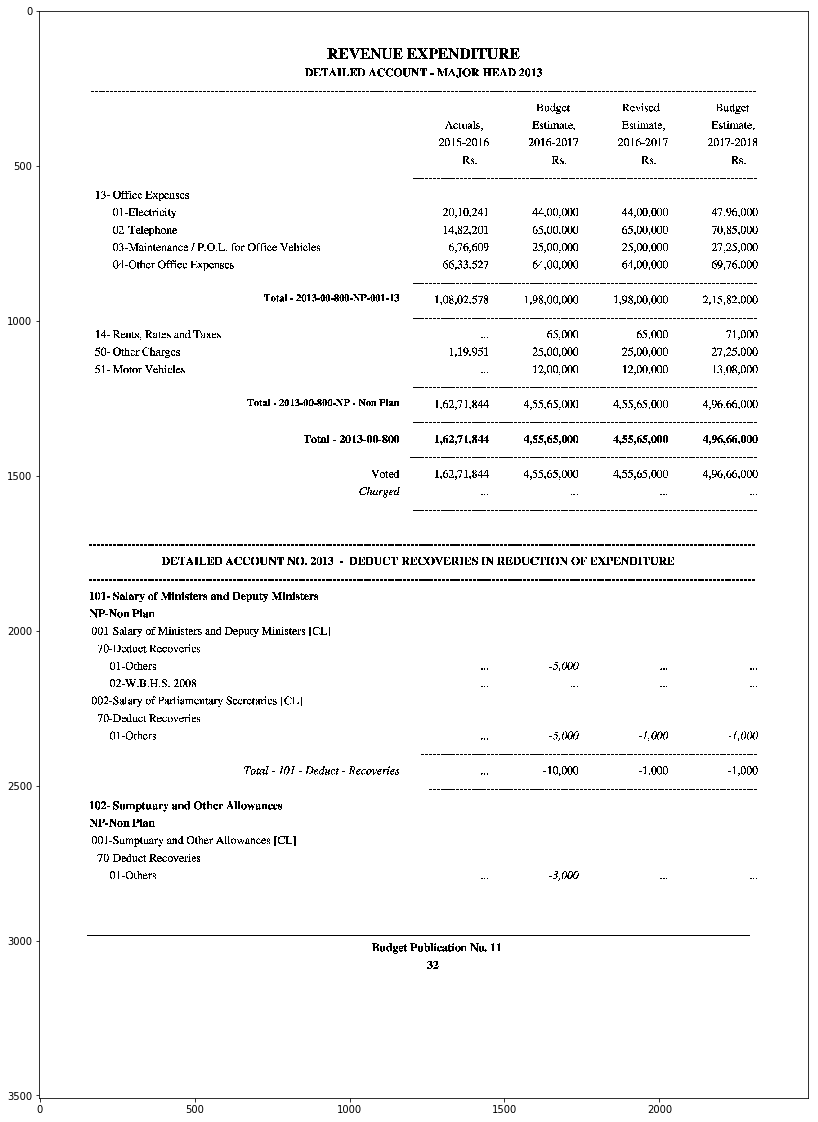

In [29]:
# Similarly we can read other documents and convert to images for processing
wb_pdf_file_path = 'pdfs/west bengal/2017-18/2017_bp11_Demand Nos.1-5.pdf'
wb_pdf = PdfFileReader(open(wb_pdf_file_path, 'rb'))

wb_page_image = get_page_image_from_pdf(33, 'west_bengal_sample.png', wb_pdf_file_path)

plt.figure(figsize=(30,20))
plt.imshow(wb_page_image, cmap='gray')

To generalize these kind of variations in the types of pdf we are now going to define them as 

    sample 1 : Tables with boundaries
    sample 2 : Tables without boundaries

## Extracting Tables with Boundaries


    - Identify Lines
        - Vertical
        - Horizontal
    - Draw Biggest Contour
    - Extract Useful Table Attributes
    - Convert to tabular data aka csv using Tabula

### Identify Lines

We use something called as Hough Transform to detect vertical and horizontal lines.

    cv2.HoughLines(), cv2.HoughLinesP()


In [30]:
HTML('<img src="http://opencv-python-tutroals.readthedocs.io/en/latest/_images/houghlinesdemo.gif">')

In [31]:
def plot_page(img):
    plt.figure(figsize=(30,20))
    plt.imshow(img, cmap='gray')


def plot_lines_on_image(lines, img):
    canvas = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) 
    for line in lines:
        x1,y1,x2,y2 = line[0]
        cv2.line(canvas,(x1,y1),(x2,y2),(255,0,255),10)
    plot_page(canvas)

## Using Hough Transform

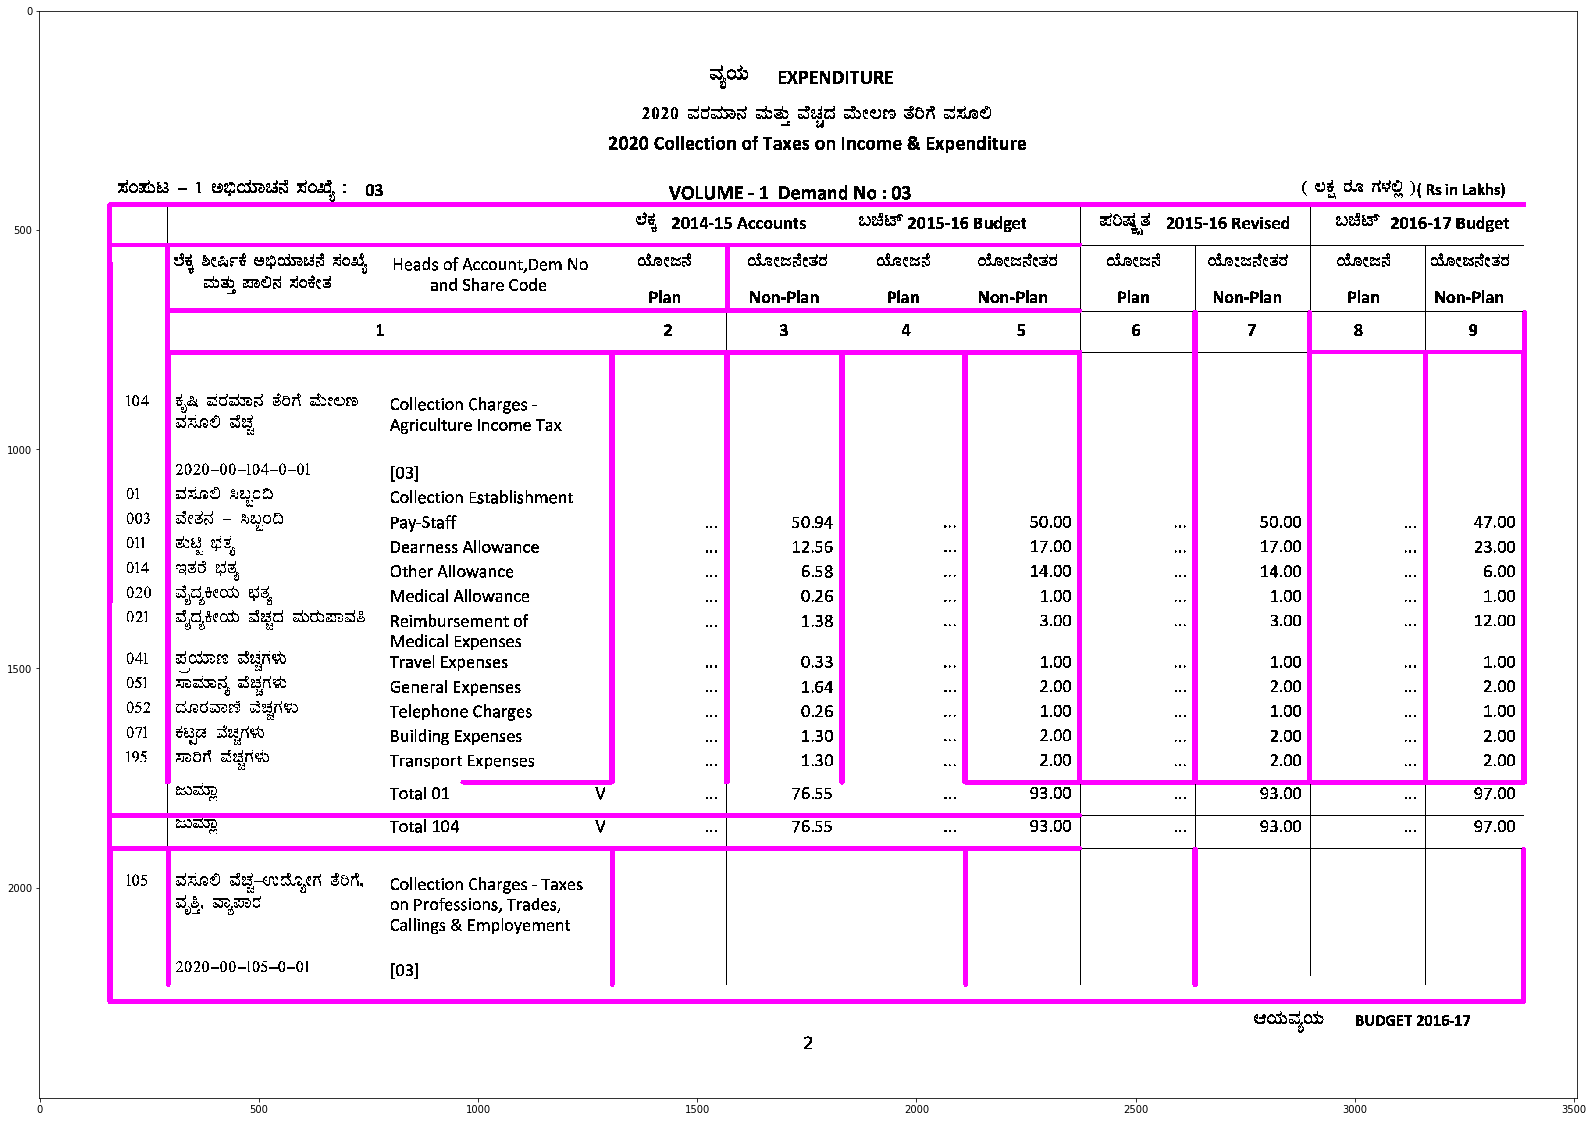

In [32]:
import numpy as np

def get_straight_lines(img, aperture_size=3):                                                                                                         
    '''Extract long straight lines using Probabilistic Hough Transform
    '''
    edges = cv2.Canny(img, 100, 150, apertureSize=aperture_size)
    min_line_length = 100                                                                                                     
    max_line_gap = 100
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, 80, min_line_length,
                            max_line_gap)
    return lines


lines = get_straight_lines(kn_page_image)
plot_lines_on_image(lines, kn_page_image)

## Converting Lines to Table Attributes

    - Table Boundaries
        - Top
        - Bottom
    - Columns
        - List of Positions where columns are detected

The Reason why we want to extract such specific table attributes is the use of an open source tool called `Tabula`

Tabula converts a pdf given a page number and the table attributes of the page into a csv file.

In [33]:
#TODO: Add table boundary extraction code.
# Table Detection using Contours


In [34]:
#TODO: Add Column Extraction Code. 
# Extending vertical lines 
# 

In [35]:
#TODO: Tabula in action.

Even though Tabula makes the job really easy for us, its not the silver bullet and it did not scale across different state budgets.

- There would be cases where tabula would merge 2 rows.
- Hough Transform couldn't detect lines without columnar lines present in the table, west bengal budget document.

## Extracting Table Without Boundaries 

## Make a machine work like humans perceive tables

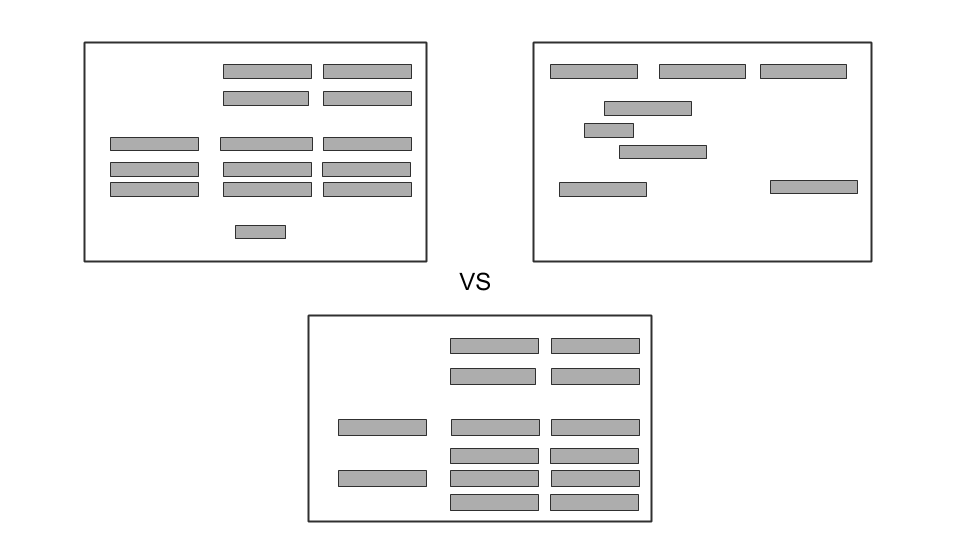

In [36]:
Image('table_post_it_like.png')

So if you Imagine each block of text as post-its or just rectangular structures, humans can distinguish between a tabular strucutre from a non tabular structure.

    Left : Tabular
    Right : Non Tabular
    Bottom : Tabular

## Extracting Geometrical features

    - Extract Blocks from Page Image.
    - Extract geometrical features of each block.
    

## Extract Blocks From Page Image

    We use a modified version of the Run Length Smoothing Algorithm (RLSA)
    
    RLSA convert a byte sequence `x` into `y` based on two rules : -
    
    1. 0's in x are changed to 1 if their is 1 in the next C adjacent bytes.
    2. 1's remain unchanged.
    
    C here is a threshold
    

In [37]:
x = [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]

def rlsa(x, C):
    y = []
    for index, value in enumerate(x):
        if value == 1:
            y.append(1)
        else:
            check_1s = sum(x[index:index + C + 1]) > 0
            if check_1s:
                y.append(1)
            else:
                y.append(0)
    return y

print(rlsa(x, 3))

[1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0]


In [38]:
def rlsa_2d(img, threshold):
    ret,thresh1 = cv2.threshold(img, 0, 1, cv2.THRESH_BINARY_INV)
    img_iter = np.nditer(thresh1, flags=['multi_index'])
    C_vertical, C_horizontal = threshold
    temp_thresh = thresh1.copy()
    while not img_iter.finished:
        x, y = img_iter.multi_index
        x_threshold = x + C_horizontal
        y_threshold = y + C_vertical
        neg_x_threshold = x - C_horizontal
        neg_y_threshold = y - C_vertical
        if (thresh1[x:x_threshold, y:y_threshold].any() 
            or thresh1[x:x_threshold, y:neg_y_threshold].any()
            or thresh1[x:neg_x_threshold, y:y_threshold].any()
            or thresh1[x:neg_x_threshold, y:neg_y_threshold].any()):
            temp_thresh[x, y] = 1
        else:
            temp_thresh[x, y] = 0
        img_iter.iternext()
    return temp_thresh

### But we are dealing with a 2 dimensional space if we convert the image to a binary.
    
       Thus our threshold C will change to (Cx,Cy)
           
           - Cx being horizontal threshold.
           - Cy being vertical threshold.


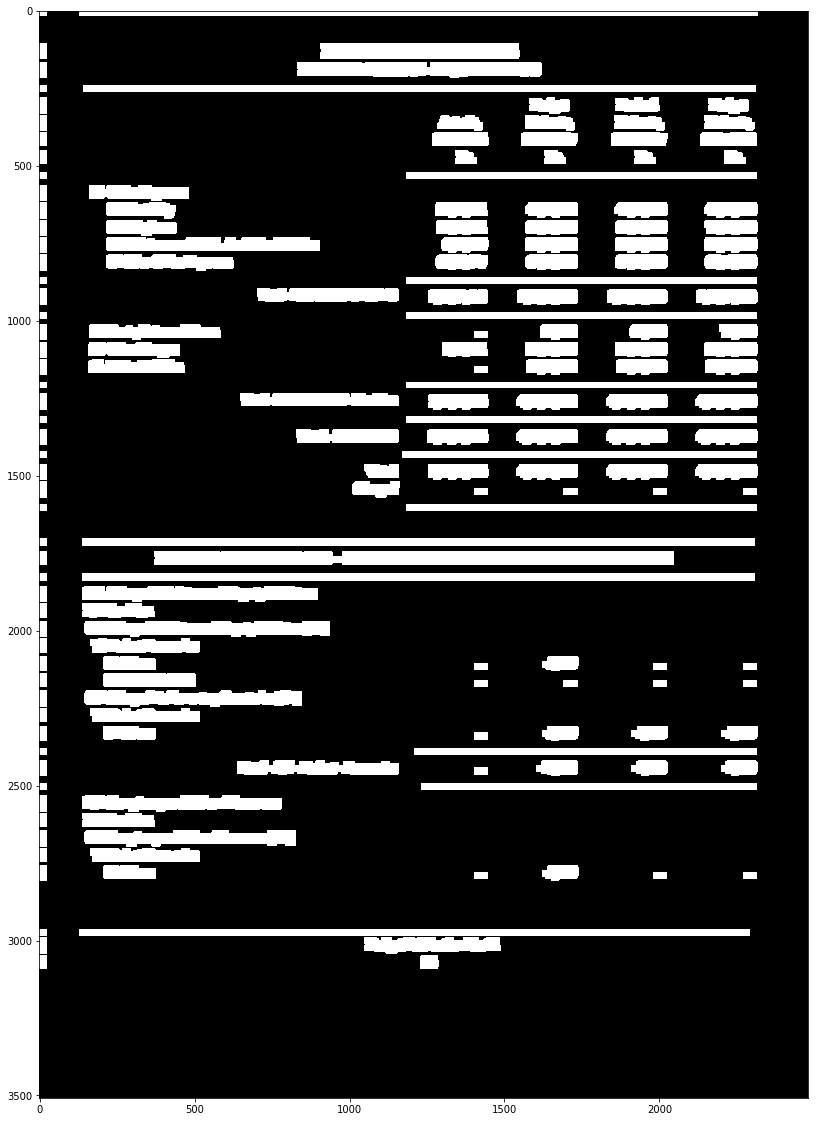

In [39]:
threshold = (25, 20)
wb_image_rlsa = rlsa_2d(wb_page_image, threshold)
plot_page(wb_image_rlsa)

## Extracting Features Using OpenCV

This is probably the easiest part    

    Use cv2.connectedComponentsWithStats()

In [40]:
import pandas as pd

n_comp, labels, stats, centroids = cv2.connectedComponentsWithStats(wb_image_rlsa)

def get_block_stats(stats, centroids):
    '''
    Convert stats into a combined dataframe.
    '''
    stats_columns = ["left", "top", "width", "height", "area"]
    block_stats = pd.DataFrame(stats, columns=stats_columns)
    block_stats['centroid_x'], block_stats['centroid_y'] = centroids[:, 0], centroids[:, 1]
    # Ignore the label 0 since it is the background
    block_stats.drop(0, inplace=True)
    # Add right, bottom and position
    return block_stats

block_stats = get_block_stats(stats, centroids)
block_stats.head(10)

,left,top,width,height,area,centroid_x,centroid_y
1,0,0,25,20,500,12.000000,9.500000
2,130,0,2188,20,43760,1223.500000,9.500000
3,0,105,25,54,1350,12.000000,131.500000
4,906,105,643,54,34128,1226.833304,131.129249
5,0,169,25,49,1225,12.000000,193.000000
6,833,169,789,49,35613,1227.420240,191.262853
7,0,242,25,22,550,12.000000,252.500000
8,143,242,2168,22,47696,1226.500000,252.500000
9,0,282,25,54,1350,12.000000,308.500000
10,1579,282,133,54,5931,1644.686562,307.158827


connected components with stats provide geometrical details about all the blocks that we generated using the modified rlsa

It provides :- 
    
    - number of components
    - labels
    - stats which include 
        - leftmost point
        - topmost point
        - height
        - width
        - area
    - centroid for each block.
    
and for convinience we can generate bottom and right.